# Word Embeddings con word2vec

In [1]:
import numpy as np
import os

In [2]:
class Document:
    
    def __init__(self, document_path, user_info_dict):
        self.document_path = document_path
        self.doc_id = None
        self.split = None
        self.topic = None
        self.age = None
        self.gender = None
        self._load_doc_info(document_path, user_info_dict)
        self.tokens = []
        self.features = None
        
    def _load_doc_info(self, document_path, user_info_dict):
        self.doc_id = document_path.split('/')[-1].split('.')[0]
        self.split = user_info_dict[self.doc_id]['split']
        self.topic = user_info_dict[self.doc_id]['topic']
        self.age = user_info_dict[self.doc_id]['age']
        self.gender = user_info_dict[self.doc_id]['gender']
             
    def __str__(self):
        return ' '.join([token.word for token in self.tokens])
    
    
class Token:
    
    def __init__(self, word, pos):
        self.word = word
        self.pos = pos

    def __str__(self):
        return f'Word = {self.word}, POS = {self.pos}'

## Caricamento dei word embeddings

Il file contiene una riga per ogni parola, con elementi separati da "\t".

Il primo elemento è la parola, i successivi 32/64/128 sono le componenti dell'embedding.

**,**	-0.1379222720861435	0.10580313950777054	-0.0127012450248003	-0.016602231189608574	0.032456133514642715	...  
**di**	0.0009638422634452581	0.07985366135835648	0.25092244148254395	-0.12702730298042297	0.008820039220154285	...  
**.**	0.07674037665128708	0.10339765250682831	0.03321867063641548	-0.19880209863185883	0.060914188623428345	...  
**e**	-0.0384422168135643	0.1741846352815628	0.054846569895744324	-0.1321409046649933	-0.10186589509248734	...  
**che**	-0.16482998430728912	0.14393456280231476	0.10551208257675171	0.2777891457080841	-0.262162446975708	...

Dobbiamo ricordarci di convertire le componenti da **stringhe** a **float**.

In [3]:
embeddings_dim = 32
embeddings_path = f'data/word_embeddings/itwac{embeddings_dim}.txt'

Leggiamo il file dei word embeddings e creiamo un dizionario della forma:
- Chiave = parola
- Valore = embedding della parola

In [4]:
def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [5]:
embeddings = load_word_embeddings(embeddings_path)

In [6]:
embeddings['vedersi'] #, embeddings['veder-']

array([ 0.10949107, -0.12286978,  0.11641154,  0.17017075,  0.24658015,
       -0.18262769,  0.30469814,  0.21135296,  0.1471802 , -0.01843514,
       -0.12676404,  0.05465349, -0.35320389,  0.02981323,  0.2520377 ,
        0.06308851, -0.0790691 , -0.13654596,  0.03764106, -0.11046565,
        0.08085832,  0.21672083, -0.07570078, -0.26205689, -0.11601808,
        0.38162684,  0.24362694, -0.04126684,  0.08113471, -0.04481747,
       -0.22317572,  0.13983752])

## Studio dello spazio dei word embeddings

Guardiamo in che range variano le componenti degli embeddings

In [7]:
min_value = 99999
max_value = -99999
for word in embeddings:
    for comp in embeddings[word]:
        if comp > max_value:
            max_value = comp
        elif comp < min_value:
            min_value = comp

print(f'Valore minimo = {min_value}')
print(f'Valore massimo = {max_value}')

Valore minimo = -0.8231641054153442
Valore massimo = 0.7768009901046753


### Visualizzazione delle parole

Ogni embedding rappresenta un **punto** in uno spazio 32/64/128-dimensionale, cioè è un punto con 32,64 o 128 coordinate.  

Non siamo in grado di rappresentare uno spazio con così tante dimensioni quindi utilizziamo una tecnica di riduzione delle dimensionalità per mappare i nostri punti in uno spazio a 2 dimensioni, che è facilmente rappresentabile.

Come algoritmo di riduzione della dimensionalità utilizziamo **TSNE**: modella i punti in modo che oggetti vicini nello spazio originale risultino vicini nello spazio a dimensionalità ridotta, e oggetti lontani risultino lontani.

L'input di TSNE è una matrice, con una riga per ogni punto e dove le colonne rappresentano le coordinate dei punti. 

L'output è una matrice con una riga per ogni punto, dove le colonne rappresentano sempre le coordinate dei punti **MA** nello spazio ridotto.

In [8]:
words = ['mela', 'pera', 'banana', 'arancia', 'kiwi', 'mandarino', 'automobile', 'camion', 'pullman', 'moto', 'bici', 'autobus']

embs = [embeddings[word] for word in words] 
embs = np.stack(embs, axis=0) # la funzione stack "attacca" una lista di vettori, creando una matrice

In [9]:
embs.shape

(12, 32)

In [10]:
a = np.array([1, 2])
b = np.array([1, 2])
c = np.array([3, 4])

np.stack([a,b,c], axis=1)

array([[1, 1, 3],
       [2, 2, 4]])

In [11]:
from sklearn.manifold import TSNE
reduced_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embs)

In [12]:
reduced_embs.shape

(12, 2)

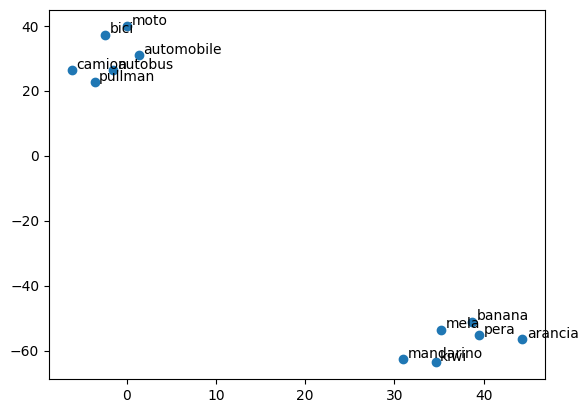

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(reduced_embs[:,0], reduced_embs[:,1])
for i, word in enumerate(words):
    ax.annotate(word, (reduced_embs[i,0]+0.5, reduced_embs[i, 1]+0.5))

## Operazioni tra embeddings

### Calcolo della distanza tra embeddings

- Distanza del coseno
<br />
$$
d(X, Y) = 1 - \textsf{cosine\_similarity}(X, Y) = 1 - \frac{X \cdot Y}{\|X\| \cdot \|Y\|} = \frac{(x_1\cdot y_1)+(x_2 \cdot y_2)+ ... + (x_n \cdot y_n)}{\sqrt{x_1^2+x_2^2+ ... + x_n^2} \cdot \sqrt{y_1^2+y_2^2+ ... + y_n^2}}
$$
<br />

- Distanza euclidea
<br />

$$
d(X, Y) = \|X - Y\|=  \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^2}
$$

<br />

![Distanze](data/img/distances.png "distances")

In [14]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

def cosine_distance(a, b):
    # cos_sim = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]
    cos_sim = np.dot(a, b)/(norm(a)*norm(b))
    return 1 - cos_sim

def euclidean_distance(a, b):
     return norm(a - b)

In [15]:
emb_mela = embeddings['mela']
emb_pera = embeddings['pera']
emb_bici = embeddings['bici']
emb_moto = embeddings['moto']

In [16]:
emb_mela

array([-0.16397248, -0.11353099,  0.12216785, -0.35035691, -0.05329633,
        0.08225409,  0.06377868,  0.02567746, -0.24116203,  0.05889656,
        0.03058628,  0.0223694 , -0.21252134,  0.13457763, -0.24546327,
       -0.29463094, -0.11019323,  0.07885154,  0.34577277, -0.05511761,
       -0.06024574,  0.22111602, -0.02894947, -0.19965613, -0.20610903,
        0.1023918 , -0.21026959,  0.26406327, -0.06659213,  0.05980551,
       -0.35431862,  0.01325086])

### Esempio distanza del coseno

In [17]:
print(f'Distanza mela - pera: {cosine_distance(emb_mela, emb_pera)}')
print(f'Distanza mela - bici: {cosine_distance(emb_mela, emb_bici)}')
print(f'Distanza bici - moto: {cosine_distance(emb_bici, emb_moto)}')

Distanza mela - pera: 0.10623314257226724
Distanza mela - bici: 0.5559857543088451
Distanza bici - moto: 0.25370661901284564


### Esempio distanza euclidea

In [18]:
print(f'Distanza mela - pera: {euclidean_distance(emb_mela, emb_pera)}')
print(f'Distanza mela - bici: {euclidean_distance(emb_mela, emb_bici)}')
print(f'Distanza bici - moto: {euclidean_distance(emb_bici, emb_moto)}')

Distanza mela - pera: 0.4609406468607129
Distanza mela - bici: 1.0545005628214927
Distanza bici - moto: 0.712329448084529


## Aggregazione di embedding

Abbiamo i word embedding di più parole e vogliamo costruire un embedding "complessivo" che contenga tutte le informazioni contenute nelle singole parole. 

Si possono adottare diverse strategie di aggregazione, per esempio:
- Somma
- Media
- Prodotto

In [19]:
words = ['mela', 'pera', 'banana', 'arancia', 'kiwi', 'mandarino']

embs = [embeddings[word] for word in words]
embs = np.stack(embs, axis=0)

emb_frutta = embeddings['frutta']

In [20]:
embs.shape

(6, 32)

In [21]:
sum_embs = np.sum(embs, axis=0)
mean_embs = np.divide(sum_embs, embs.shape[0])
max_embs = np.max(embs, axis=0)
prod_embs = np.prod(embs, axis=0)

In [22]:
print('Embedding somma:\n', sum_embs)
print('\nEmbedding media:\n', mean_embs)
print('\nEmbedding max:\n', max_embs)
print('\nEmbedding prodotto:\n', prod_embs)

Embedding somma:
 [-1.77744471 -0.50418537  0.80661957 -1.90676925 -0.12335913  0.6158017
  0.12923692  0.32734836 -0.93968811  0.02313449  0.08489703  0.18612213
 -1.15985482  0.57251764 -0.6066124  -1.16921454 -0.42062461 -0.00262572
  1.65596417 -0.42854384 -1.35362885  0.55290788 -0.32421874 -1.05324327
 -0.96034713  1.03172622 -1.37570074  1.71420068 -0.15996295  0.70514092
 -1.23877383  0.33319741]

Embedding media:
 [-0.29624078 -0.0840309   0.1344366  -0.31779487 -0.02055985  0.10263362
  0.02153949  0.05455806 -0.15661468  0.00385575  0.01414951  0.03102035
 -0.19330914  0.09541961 -0.10110207 -0.19486909 -0.0701041  -0.00043762
  0.27599403 -0.07142397 -0.22560481  0.09215131 -0.05403646 -0.17554055
 -0.16005786  0.17195437 -0.22928346  0.28570011 -0.02666049  0.11752349
 -0.20646231  0.0555329 ]

Embedding max:
 [-0.16397248  0.01555634  0.25971061 -0.22217058  0.13510679  0.2606768
  0.15144718  0.19999215 -0.06124532  0.05889656  0.13541867  0.1509577
 -0.04113042  0.17116

Valutiamo le diverse aggregazioni.

In [23]:
print(f'Distanza somma - frutta: {cosine_distance(sum_embs, emb_frutta)}')
print(f'Distanza media - frutta: {cosine_distance(mean_embs, emb_frutta)}')
print(f'Distanza max - frutta: {cosine_distance(max_embs, emb_frutta)}')
print(f'Distanza prodotto - frutta: {cosine_distance(prod_embs, emb_frutta)}')

Distanza somma - frutta: 0.18639702971381067
Distanza media - frutta: 0.1863970297138109
Distanza max - frutta: 0.31652536817010213
Distanza prodotto - frutta: 1.1197124556982374


In [24]:
print(f'Distanza somma - frutta: {euclidean_distance(sum_embs, emb_frutta)}')
print(f'Distanza media - frutta: {euclidean_distance(mean_embs, emb_frutta)}')
print(f'Distanza max - frutta: {cosine_distance(max_embs, emb_frutta)}')
print(f'Distanza prodotto - frutta: {euclidean_distance(prod_embs, emb_frutta)}')

Distanza somma - frutta: 4.514841362790446
Distanza media - frutta: 0.5854077071479116
Distanza max - frutta: 0.31652536817010213
Distanza prodotto - frutta: 1.0001449590192055


## Rappresentazione di un documento utilizzando i word embeddings delle parole che contiene

Si possono utilizzare tutti i metodi di aggregazione visti sopra.

In più:
- Si può decidere di aggregare solo parole che hanno determinate part-of-speech
- Si possono aggregare le diverse part-of-speech separatamente

![Distanze](data/img/doc_embedding.png "distances")

## Caricamento dataset

In [25]:
conllu_dir = 'data/Tag-it/profiling_output/linguistic_annotation'
user_info_path  = 'data/Tag-it/preprocessed_dataset/user_info.json'

In [26]:
import json

def load_user_info(src_path):
    with open(src_path, 'r') as src_file:
        user_info = json.load(src_file)
    return user_info

In [27]:
user_info_dict = load_user_info(user_info_path)

### Normalizzazione delle parole


- Numbers:
    1. Integer numbers between 0 and 2100 were kept as original
    2. Each integer number greater than 2100 is mapped in a string which represents the number of digits needed to store the number (ex: 10000 -> DIGLEN_5)
    3. Each digit in a string that is not convertible to a number must be converted with the following char: @Dg. This is an example of replacement (ex: 10,234 -> @Dg@Dg,@Dg@Dg@Dg)
- Words:
    1. A string starting with lower case character must be lowercased (e.g.: (“aNtoNio” -> “antonio”), (“cane” -> “cane”))
    2. A string starting with an upcased character must be capitalized (e.g.: (“CANE” -> “Cane”, “Antonio”-> “Antonio”))


In [1]:
import re

def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub(r'\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [29]:
def get_tokens_from_file_clitics(src_path):
    document_tokens = []
    for line in open(src_path, 'r'):
        if line[0].isdigit():          # se la riga inizia con un numero
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = Token(word=word, pos=pos)
                document_tokens.append(token)
    return document_tokens

In [30]:
def get_tokens_from_file(src_path):
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = Token(word=word, pos=None) # inizializziamo il token con la forma, il pos lo prendiamo nella riga successiva
                # print(f'Preso token {word}')
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:   
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = Token(word=word, pos=pos)
                    # print(f'Preso token {word}')
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1].pos = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return document_tokens

In [31]:
file_prova = 'prova_clitici.txt'
token_prova = get_tokens_from_file(file_prova)
for token in token_prova:
    print(token)

Word = Sono, POS = AUX
Word = io, POS = PRON
Word = che, POS = PRON
Word = ringrazio, POS = VERB
Word = te, POS = PRON
Word = per, POS = ADP
Word = averla, POS = VERB
Word = letta, POS = NOUN
Word = e, POS = CCONJ
Word = commentata, POS = VERB
Word = ., POS = PUNCT


In [32]:
all_documents = []

for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)

    if '.ipynb_checkpoints' not in file_path:
        document = Document(file_path, user_info_dict)
        document_tokens = get_tokens_from_file(file_path)
        document.tokens = document_tokens
        all_documents.append(document)

In [33]:
print(all_documents[0])

Bella diego Guarda rispondo velocemente perchè sto per uscire . Ironizzavo su uno dei miti recenti del napoli , i cross di maggio . Senza andare a tirare i paragoni con gli altri o a sottolineare gli assist ( ci sarebbe pure quello contro la roma l' anno scorso ) era una battuta Che poi per me maggio sia da sostituire con un giocatore più giovane e di qualità superiore è un altro discorso . Hai ragione , miliardi ! Bart io ne facevo un discorso personale , ho purtroppo omesso di dirlo . Per me ha almeno 10 - 12 Kg di troppo , e sempre per me se li perdesse sarebbe una pietra . Ecco Per il resto sono d' accordo con te . Sono il primo a demonizzare gli standard e i canoni . Ora non la conosco e la percezione che ho di lei è solo da foto e non posso sapere se sia realmente a suo agio o no , sta di fatto che per molti ( me compreso ) il peso eccessivo è stato proprio la causa di un disagio con se stessi e di conseguenza difficoltà relazionali con gli altri . Ora che sono in forma non sono 

## Estrazione features

Creiamo la rappresentazione di un document aggregando i word embeddings di tutte le sue parole. 

Come "funzione di aggregazione" useremo la media.

In [34]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

Metodo che calcola la media di tutti i word embeddings di un documento.

In [35]:
def compute_all_embeddings_mean(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token.word
        if word in embeddings:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

Metodo che calcola la media dei word embeddings solo di aggettivi, nomi e verbi.

In [36]:
def compute_filtered_embeddings_mean(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token.word
        pos = token.pos
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

Metodo che calcola la media separatamente dei word embedding di aggettivi, nomi e verbi, e concatena i 3 vettori ottenuti.

In [37]:
def compute_filtered_embeddings_sep_means(document_tokens):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    
    for token in document_tokens:
        word = token.word
        pos = token.pos
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        mean_adj_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adj_embeddings = compute_embeddings_mean(adj_embeddings)
        
    if len(noun_embeddings) == 0:
        mean_noun_embeddings = np.zeros(embeddings_dim)
    else:
        mean_noun_embeddings = compute_embeddings_mean(noun_embeddings)
        
    if len(verb_embeddings) == 0:
        mean_verb_embeddings = np.zeros(embeddings_dim)
    else:
        mean_verb_embeddings = compute_embeddings_mean(verb_embeddings)  
    
    
    mean_document_embeddings = np.concatenate([mean_adj_embeddings, mean_noun_embeddings, mean_verb_embeddings], axis=None)
    return mean_document_embeddings

In [38]:
doc_0_tokens = all_documents[0].tokens
print('Media di tutti gli embeddings:')
print(compute_all_embeddings_mean(doc_0_tokens))
print('\nMedia embeddings parole piene:')
print(compute_filtered_embeddings_mean(doc_0_tokens))
print('\nMedia separate embeddings parole piene:')
print(compute_filtered_embeddings_sep_means(doc_0_tokens))

Media di tutti gli embeddings:
[-0.00713581  0.03216588  0.08470808  0.04056166 -0.036426   -0.10610584
 -0.02649192  0.08309942  0.04600836 -0.02382926 -0.03004765  0.01476899
 -0.08904861 -0.01672743  0.04971395  0.06194596 -0.0268447   0.0631904
  0.05277431  0.00782678  0.00601618  0.16688959 -0.01413066 -0.08642725
  0.02441294  0.21679938  0.11149935 -0.05573408 -0.0152927  -0.11067854
 -0.08487639  0.06851828]

Media embeddings parole piene:
[ 0.01114323  0.00831943  0.05746088  0.01721215 -0.01993141 -0.08395901
  0.04528596  0.06360036  0.0003606  -0.03316704  0.04341567  0.03271513
 -0.07184879 -0.0545466   0.03525446  0.01522552  0.03920035  0.03283741
 -0.00263034 -0.03716881  0.01391663  0.17095081 -0.03631201 -0.10840766
  0.06070613  0.09156226  0.02729972  0.04199313  0.00686639  0.01744403
 -0.04569278  0.03293955]

Media separate embeddings parole piene:
[-0.03945314  0.04261469  0.12052023 -0.04867628 -0.07202009 -0.06390105
 -0.01614592  0.09488563  0.01482562 -0.00

### Creazione della matrice delle features del training set  

Ogni utente è rappresentato dall'aggregazione dei word embeddings delle parole dei suoi post.

In [39]:
def extract_features(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings = compute_filtered_embeddings_mean(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings

In [40]:
extract_features(all_documents)

In [41]:
all_documents[0].features

array([ 0.01114323,  0.00831943,  0.05746088,  0.01721215, -0.01993141,
       -0.08395901,  0.04528596,  0.06360036,  0.0003606 , -0.03316704,
        0.04341567,  0.03271513, -0.07184879, -0.0545466 ,  0.03525446,
        0.01522552,  0.03920035,  0.03283741, -0.00263034, -0.03716881,
        0.01391663,  0.17095081, -0.03631201, -0.10840766,  0.06070613,
        0.09156226,  0.02729972,  0.04199313,  0.00686639,  0.01744403,
       -0.04569278,  0.03293955])

## Split train e test

In [42]:
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.topic)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.topic)
    
    return train_features_dict, train_labels, test_features_dict, test_labels

In [43]:
train_features, train_labels, test_features, test_labels = train_test_split(all_documents)
len(train_features), len(train_labels), len(test_features), len(test_labels)

(1109, 1109, 411, 411)

In [44]:
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

In [45]:
X_train.shape

(1109, 32)

### Normalizzazione

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)

# Classificazione

In [47]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=False)
svc.fit(scaled_X_train, y_train)

LinearSVC(dual=False)

In [48]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

scaled_X_test = scaler.transform(X_test)
test_predictions = svc.predict(scaled_X_test)

In [49]:
print(classification_report(y_test, test_predictions,  zero_division=0))

                     precision    recall  f1-score   support

              ANIME       0.68      0.93      0.78        97
          AUTO-MOTO       0.69      0.75      0.72        76
              BIKES       0.00      0.00      0.00        12
        CELEBRITIES       0.81      0.59      0.68        22
      ENTERTAINMENT       0.00      0.00      0.00         9
MEDICINE-AESTHETICS       0.71      0.31      0.43        16
    METAL-DETECTING       0.56      0.35      0.43        26
             NATURE       0.86      0.55      0.67        11
              SMOKE       0.92      0.77      0.84        30
             SPORTS       0.76      0.91      0.83       103
         TECHNOLOGY       0.00      0.00      0.00         9

           accuracy                           0.72       411
          macro avg       0.54      0.47      0.49       411
       weighted avg       0.67      0.72      0.68       411



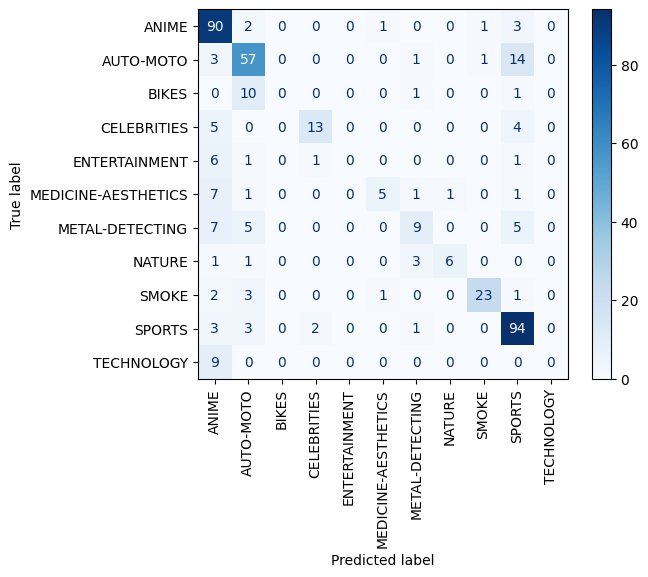

In [50]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');

# Riferimenti

- Tutorial CLIC-it 2020 Alessandro Lenci: Distributional Semantics: Yesterday, Today, and Tomorrow:
    - [Abstract](https://ceur-ws.org/Vol-2769/abstract_AL.pdf)
    - [Video](https://vimeo.com/526128547)
- [Blog Jay Alammar: The illustrated word2vec](https://jalammar.github.io/illustrated-word2vec/)

### Letture cosnigliate

- [Word Representations: A Simple and General Method for Semi-Supervised Learning](https://aclanthology.org/P10-1040/). Joseph Turian, Lev-Arie Ratinov, Yoshua Bengio, ACL 2010
- [Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors](https://aclanthology.org/P14-1023/). Marco Baroni, Georgiana Dinu, Germán Kruszewski, ACL 2014